## Imports & setup

In [1]:
import pandas as pd
import sqlite3
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

## Load both Excel sheets

In [3]:
data_path = Path("online_retail_II.xlsx")

df_2009 = pd.read_excel(data_path, sheet_name="Year 2009-2010")
df_2010 = pd.read_excel(data_path, sheet_name="Year 2010-2011")

df_raw = pd.concat([df_2009, df_2010], ignore_index=True)

df_raw.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


## Data Cleaning

In [5]:
df = df_raw.copy()

# Rename columns for consistency
df.columns = [
    "invoice",
    "product_id",
    "product_name",
    "quantity",
    "invoice_date",
    "unit_price",
    "customer_id",
    "country"
]

# Drop rows with missing customer_id
df = df[df["customer_id"].notna()]

# Convert customer_id to integer
df["customer_id"] = df["customer_id"].astype(int)

# Remove cancelled invoices (Invoice starting with 'C')
df = df[~df["invoice"].astype(str).str.startswith("C")]

# Remove invalid quantities and prices
df = df[(df["quantity"] > 0) & (df["unit_price"] > 0)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805549 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       805549 non-null  object        
 1   product_id    805549 non-null  object        
 2   product_name  805549 non-null  object        
 3   quantity      805549 non-null  int64         
 4   invoice_date  805549 non-null  datetime64[ns]
 5   unit_price    805549 non-null  float64       
 6   customer_id   805549 non-null  int32         
 7   country       805549 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 52.2+ MB


## Create customers table

In [6]:
customers = (
    df[["customer_id", "country"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

customers.head()

,customer_id,country
0,13085,United Kingdom
1,13078,United Kingdom
2,15362,United Kingdom
3,18102,United Kingdom
4,12682,France


## Create products table

In [7]:
products = (
    df[["product_id", "product_name"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

products.head()

,product_id,product_name
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,79323P,PINK CHERRY LIGHTS
2,79323W,WHITE CHERRY LIGHTS
3,22041,"RECORD FRAME 7"" SINGLE SIZE"
4,21232,STRAWBERRY CERAMIC TRINKET BOX


## Orders table

In [8]:
orders = (
    df[["invoice", "customer_id", "invoice_date"]]
    .drop_duplicates()
    .rename(columns={
        "invoice": "order_id",
        "invoice_date": "order_date"
    })
    .reset_index(drop=True)
)

orders.head()

,order_id,customer_id,order_date
0,489434,13085,2009-12-01 07:45:00
1,489435,13085,2009-12-01 07:46:00
2,489436,13078,2009-12-01 09:06:00
3,489437,15362,2009-12-01 09:08:00
4,489438,18102,2009-12-01 09:24:00


## Create Order Items table

In [9]:
order_items = (
    df[["invoice", "product_id", "quantity", "unit_price"]]
    .rename(columns={"invoice": "order_id"})
    .reset_index(drop=True)
)

order_items.head()

,order_id,product_id,quantity,unit_price
0,489434,85048,12,6.95
1,489434,79323P,12,6.75
2,489434,79323W,12,6.75
3,489434,22041,48,2.10
4,489434,21232,24,1.25


## Create SQLite connection

In [10]:
import sqlite3

conn = sqlite3.connect("online_retail.db")

## Write tables to SQLite

In [11]:
customers.to_sql("customers", conn, if_exists="replace", index=False)
products.to_sql("products", conn, if_exists="replace", index=False)
orders.to_sql("orders", conn, if_exists="replace", index=False)
order_items.to_sql("order_items", conn, if_exists="replace", index=False)

805549

## Verify tables & row counts

In [12]:
pd.read_sql(
    "SELECT COUNT(*) AS total_customers FROM customers;",
    conn
)

,total_customers
0,5891


In [13]:
pd.read_sql(
    "SELECT COUNT(*) AS total_products FROM products;",
    conn
)

,total_products
0,5315


In [14]:
pd.read_sql(
    "SELECT COUNT(*) AS total_orders FROM orders;",
    conn
)

,total_orders
0,37033


In [15]:
pd.read_sql(
    "SELECT COUNT(*) AS total_order_items FROM order_items;",
    conn
)

,total_order_items
0,805549


## Business KPI Queries

### Total Revenue

In [16]:
pd.read_sql(
    """
    SELECT ROUND(SUM(quantity * unit_price), 2) AS total_revenue
    FROM order_items;
    """,
    conn
)

,total_revenue
0,17743429.18


### Average Order Value

In [17]:
pd.read_sql(
    """
    SELECT 
        ROUND(SUM(oi.quantity * oi.unit_price) / COUNT(DISTINCT o.order_id), 2) 
        AS avg_order_value
    FROM orders o
    JOIN order_items oi
        ON o.order_id = oi.order_id;
    """,
    conn
)

,avg_order_value
0,480.97


### Revenue by Country (Top 10)

In [18]:
pd.read_sql(
    """
    SELECT 
        c.country,
        ROUND(SUM(oi.quantity * oi.unit_price), 2) AS revenue
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.country
    ORDER BY revenue DESC
    LIMIT 10;
    """,
    conn
)

,country,revenue
0,United Kingdom,14753408.48
1,EIRE,624928.44
2,Netherlands,554232.34
3,Germany,434596.26
4,France,357112.55
5,Australia,175124.24
6,Spain,121227.17
7,Switzerland,103566.14
8,Sweden,91549.72
9,Denmark,77072.13


### Top 10 Customers by Revenue

In [19]:
pd.read_sql(
    """
    SELECT
        c.customer_id,
        c.country,
        ROUND(SUM(oi.quantity * oi.unit_price), 2) AS total_revenue
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.customer_id, c.country
    ORDER BY total_revenue DESC
    LIMIT 10;
    """,
    conn
)

,customer_id,country,total_revenue
0,18102,United Kingdom,608821.65
1,14646,Netherlands,528602.52
2,14156,EIRE,313946.37
3,14911,EIRE,298546.11
4,17450,United Kingdom,246973.09
5,13694,United Kingdom,196482.81
6,17511,United Kingdom,178940.31
7,16446,United Kingdom,168472.50
8,16684,United Kingdom,147142.77
9,12415,Australia,144458.37


### Order count per customer

In [20]:
pd.read_sql(
    """
    SELECT
        customer_id,
        COUNT(DISTINCT order_id) AS total_orders
    FROM orders
    GROUP BY customer_id
    ORDER BY total_orders DESC
    LIMIT 10;
    """,
    conn
)

,customer_id,total_orders
0,14911,398
1,12748,336
2,17841,211
3,15311,208
4,13089,203
5,14606,192
6,14156,156
7,17850,155
8,14646,151
9,18102,145


### Customer purchase frequency distribution

In [22]:
pd.read_sql(
    """
    SELECT
        CASE
            WHEN total_orders = 1 THEN 'One-time Customer'
            ELSE 'Repeat Customer'
        END AS customer_type,
        COUNT(*) AS customer_count
    FROM (
        SELECT
            customer_id,
            COUNT(DISTINCT order_id) AS total_orders
        FROM orders
        GROUP BY customer_id
    ) customer_orders
    GROUP BY customer_type;
    """,
    conn
)

,customer_type,customer_count
0,One-time Customer,1623
1,Repeat Customer,4255


### Customer Lifetime Value

In [23]:
pd.read_sql(
    """
    SELECT
        c.customer_id,
        c.country,
        ROUND(SUM(oi.quantity * oi.unit_price), 2) AS customer_lifetime_value
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.customer_id, c.country
    ORDER BY customer_lifetime_value DESC
    LIMIT 10;
    """,
    conn
)

,customer_id,country,customer_lifetime_value
0,18102,United Kingdom,608821.65
1,14646,Netherlands,528602.52
2,14156,EIRE,313946.37
3,14911,EIRE,298546.11
4,17450,United Kingdom,246973.09
5,13694,United Kingdom,196482.81
6,17511,United Kingdom,178940.31
7,16446,United Kingdom,168472.50
8,16684,United Kingdom,147142.77
9,12415,Australia,144458.37


### Average & Median CLV

In [24]:
pd.read_sql(
    """
    SELECT
        ROUND(AVG(customer_lifetime_value), 2) AS avg_clv,
        ROUND(
            (SELECT customer_lifetime_value
             FROM (
                 SELECT
                     ROUND(SUM(oi.quantity * oi.unit_price), 2) AS customer_lifetime_value
                 FROM orders o
                 JOIN order_items oi ON o.order_id = oi.order_id
                 GROUP BY o.customer_id
                 ORDER BY customer_lifetime_value
                 LIMIT 1 OFFSET (
                     SELECT COUNT(*) / 2 FROM (
                         SELECT customer_id FROM orders GROUP BY customer_id
                     )
                 )
             )
        ), 2) AS median_clv
    FROM (
        SELECT
            SUM(oi.quantity * oi.unit_price) AS customer_lifetime_value
        FROM orders o
        JOIN order_items oi ON o.order_id = oi.order_id
        GROUP BY o.customer_id
    );
    """,
    conn
)

,avg_clv,median_clv
0,3024.98,900.11


### Revenue concentration (Top 10 customers)

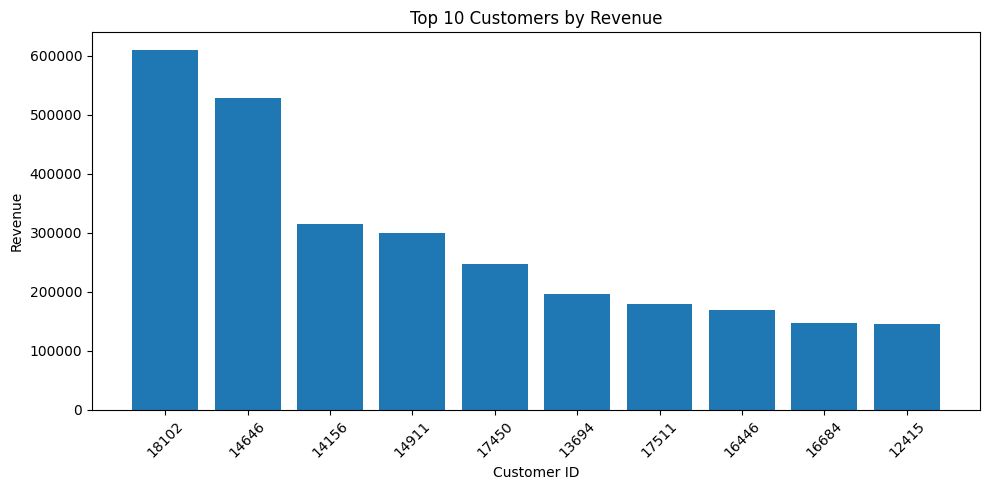

In [25]:
import matplotlib.pyplot as plt

top_customers = pd.read_sql(
    """
    SELECT
        c.customer_id,
        ROUND(SUM(oi.quantity * oi.unit_price), 2) AS revenue
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.customer_id
    ORDER BY revenue DESC
    LIMIT 10;
    """,
    conn
)

plt.figure(figsize=(10, 5))
plt.bar(top_customers["customer_id"].astype(str), top_customers["revenue"])
plt.title("Top 10 Customers by Revenue")
plt.xlabel("Customer ID")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Orders per customer distribution

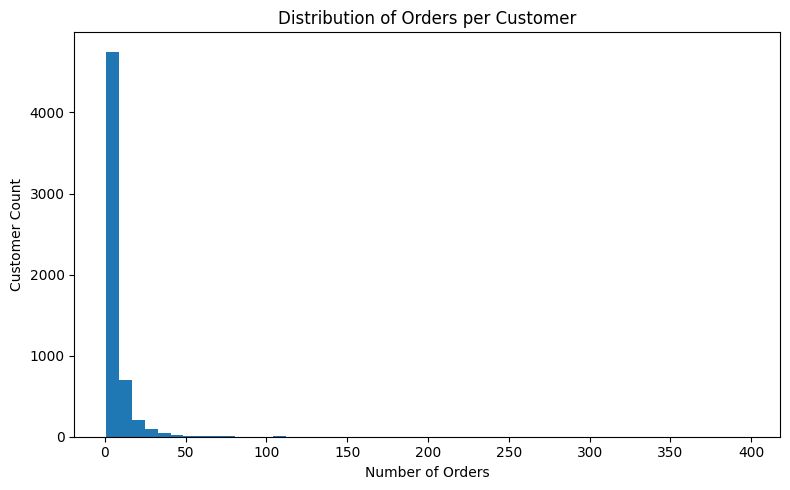

In [26]:
order_counts = pd.read_sql(
    """
    SELECT
        customer_id,
        COUNT(DISTINCT order_id) AS total_orders
    FROM orders
    GROUP BY customer_id;
    """,
    conn
)

plt.figure(figsize=(8, 5))
plt.hist(order_counts["total_orders"], bins=50)
plt.title("Distribution of Orders per Customer")
plt.xlabel("Number of Orders")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()